## Full bridge rectifier circuit with transformer

#### Transformer model definition

In [102]:
####################################################################################################

from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

####################################################################################################

class Transformer(SubCircuitFactory):

    NAME = 'Transformer'
    NODES = ('input_plus', 'input_minus',
             'output_plus', 'output_minus')

    ##############################################

    def __init__(self,
                 turn_ratio,
                 primary_inductance=1@u_H,
                 copper_resistance=1@u_Ω,
                 leakage_inductance=1@u_mH,
                 winding_capacitance=20@u_pF,
                 coupling=.999,
             ):

        super().__init__()

        # For an ideal transformer you can reduce the values for the flux leakage inductances, the
        # copper resistors and the winding capacitances. But
        if copper_resistance <= 0:
            raise ValueError("copper resistance must be > 0")
        if leakage_inductance <= 0:
            raise ValueError("leakage inductance must be > 0")

        secondary_inductance = primary_inductance / float(turn_ratio**2)

        # Primary
        self.C('primary', 'input_plus', 'input_minus', winding_capacitance)
        self.L('primary_leakage', 'input_plus', 1, leakage_inductance)
        primary_inductor = self.L('primary', 1, 2, primary_inductance)
        self.R('primary', 2, 'output_minus', copper_resistance)

        # Secondary
        self.C('secondary', 'output_plus', 'output_minus', winding_capacitance)
        self.L('secondary_leakage', 'output_plus', 3, leakage_inductance)
        secondary_inductor = self.L('secondary', 3, 4, secondary_inductance)
        self.R('secondary', 4, 'output_minus', copper_resistance)

        # Coupling
        self.CoupledInductor('coupling', primary_inductor.name, secondary_inductor.name, coupling)


#### Defining elements by their specifications

In [103]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor 
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


In [ ]:
# IMPLEMENTAR DEPOIS PARA FACILITAR
# class VoltageDivider(Circuit):

#     def __init__(self, **kwargs):

#         super().__init__(title='Voltage Divider', **kwargs)

#         self.V('input', 'in', self.gnd, '10V')
#         self.R(1, 'in', 'out', kilo(9))
#         self.R(2, 'out', self.gnd, kilo(1))

In [104]:
#######################################################################
# CIRCUIT NETLIST

circuit = Circuit('Full Wave Rectifier with Smoothing Capacitor')

# MUST be defined after the circuit call
# Defining the 1N4002 model by its especifications
circuit.model('1N4002', 'D', IS = 14.11E-11, N = 1.984, RS = 33.89E-3, IKF=94.81, XTITUN=3, KEG=1.110, CJO = 51.17E-12, M = .2762, VJ = .3905, FC = 0.5, ISR=100.0E-12, NR=2, BV=100.1, IBV=10, TT = 4.761E-6)
# Defining the 1N751 model by its especifications
circuit.model('1N751', 'D', IS = 1.004E-15, N = 1, RS = .5875, IKF=0, XTITUN=3, EG=1.11, CJO = 160E-12, M = .5484, VJ = 0.75, FC = 0.5, ISR=1.8E-9, NR=2, BV=5.1, IBV=27.721E-3, NBV=1.1779)

# Sine Source
Vrms = 110 
A=Vrms*np.sqrt(2)@u_V
f=60@u_Hz
source = circuit.SinusoidalVoltageSource('Source', 'Vs', circuit.gnd, amplitude=A, frequency=f)

# Adding resistance to measure current
circuit.R('Rc', 'Vs', 'pri', 1@u_Ω) 

# Transformer definitions
turn_ratio = 20
primary_inductance=100@u_H
copper_resistance=1@u_mΩ
leakage_inductance=1@u_uH
winding_capacitance=0@u_pF
coupling=0.9999
circuit.subcircuit(Transformer( turn_ratio,
                                primary_inductance,
                                copper_resistance,
                                leakage_inductance,
                                winding_capacitance,
                                coupling))

# When using circuit.X the class defined before is stated after the element name, in this case the word
# Transformer ( second word ) is calling the class Transformer defined before
circuit.X('transformer', 'Transformer', 'pri', circuit.gnd, 'sec_plus', 'sec_minus')

# Diode bridge
# Here we are calling the defined element befeore by stating its model with the kwarg "model" in the end
circuit.D('D1', 'sec_plus', 'smooth', model='1N4002')
circuit.D('D2', circuit.gnd, 'sec_plus', model='1N4002')
circuit.D('D3', circuit.gnd, 'sec_minus', model='1N4002')
circuit.D('D4', 'sec_minus', 'smooth', model='1N4002')

# RC filter 
circuit.R('R_1', 'smooth', 'output', 100@u_Ω)
circuit.C('1', 'smooth', circuit.gnd, 1@u_mF)

# OR if you want to include a model file (.lib) 
# USE circuit.include("1N751.lib") with the circuit model, such as:
# * -- spice --
# * http://ltwiki.org/index.php?title=Standard.dio

# *
# *.model 1N751 D(Is=1.004f Rs=.5875 Ikf=0 N=1 Xti=3 Eg=1.11 Cjo=160p
# *                M=.5484 Vj=.75 Fc=.5 Isr=1.8n Nr=2 Bv=5.1 Ibv=27.721m
# *                Nbv=1.1779 Ibvl=1.1646m Nbvl=21.894 Tbv1=176.47u
# *                Vpk=5.1 mfg=Motorola type=zener)
# *
# *****************************************
# *
# * 1N751

# .SUBCKT 1N751 1 2 

# D1 1 2 1N751
# *
# .MODEL 1N751 D 
# + IS = 1.004E-15
# + N = 1
# + RS = .5875 
# + IKF=0
# + XTITUN=3
# + EG=1.11
# + CJO = 160E-12
# + M = .5484 
# + VJ = 0.75
# + FC = 0.5
# + ISR=1.8E-9
# + NR=2
# + BV=5.1
# + IBV=27.721E-3
# + NBV=1.1779
# .ENDS
# *

# Zener and LOAD
circuit.D('Z1', 'output', circuit.gnd, model='1N751') 
circuit.R('load', 'output', circuit.gnd, 100@u_Ω)

#######################################################################
# CIRCUIT SIMULATION

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_us, end_time=80@u_ms)

#### Plotting results

C:\Users\jedua\AppData\Local\Temp\ipykernel_42684\489997005.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axe = plt.subplot(211)


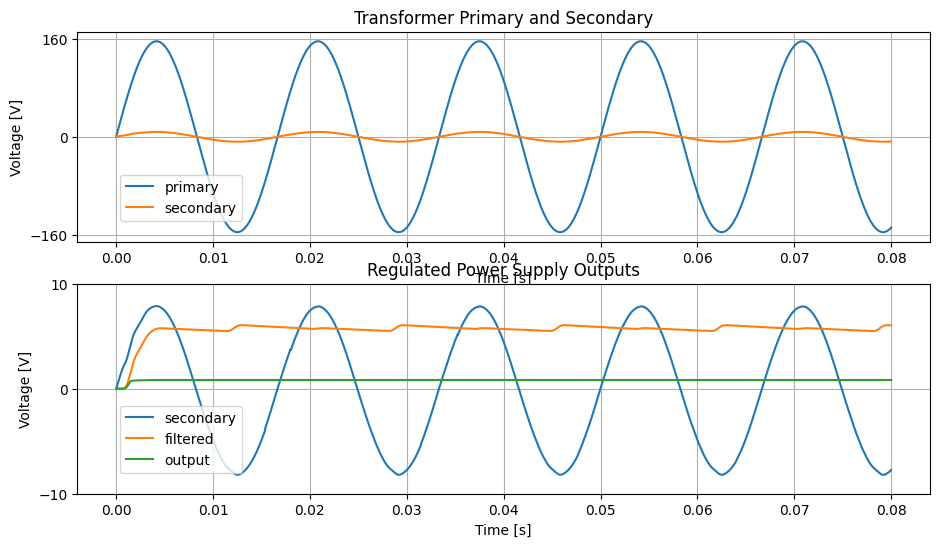

In [105]:
#######################################################################
# PLOTTING COMMANDS

figure = plt.subplots(figsize=(11, 6))

axe = plt.subplot(211)
plt.title('Transformer Primary and Secondary')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['pri'], axis=axe)
plot(analysis.sec_plus - analysis.sec_minus, axis=axe)
plt.legend(('primary', 'secondary'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))
axe.set_yticks([-160, 0, 160])

axe = plt.subplot(212)
plt.title('Regulated Power Supply Outputs')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis.sec_plus - analysis.sec_minus, axis=axe)
plot(analysis['smooth'], axis=axe)
plot(analysis['output'], axis=axe)
plt.legend(('secondary', 'filtered', 'output'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1/turn_ratio), float(source.amplitude*1.1/turn_ratio))
axe.set_yticks([-10, 0, 10])
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)

plt.show()

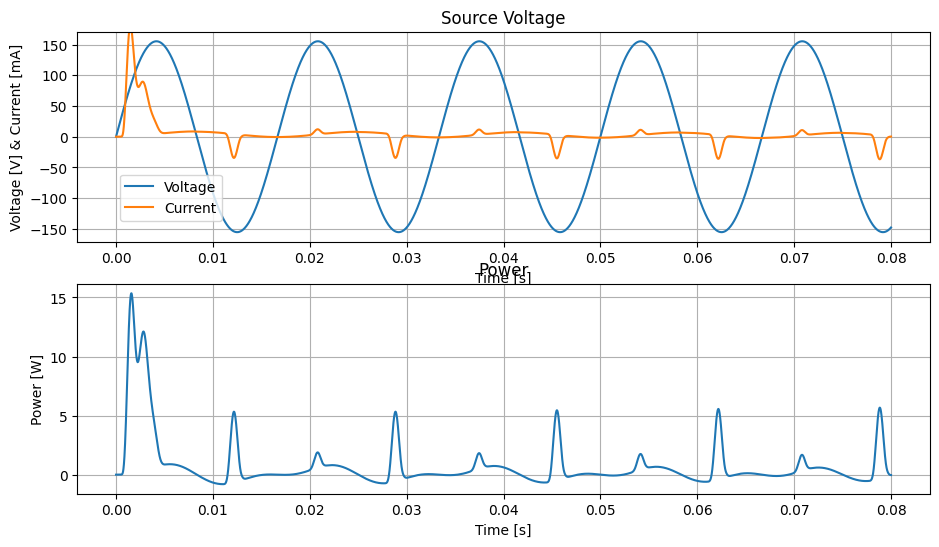

In [106]:
# Verifying the source 

plt.figure(figsize=(11, 6))
plt.subplot(2,1,1)
plt.title('Source Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V] & Current [mA]')
plt.grid()
plot(analysis['pri'])
plot((analysis['Vs']-analysis['pri'])*1000)
plt.legend(('Voltage', 'Current'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))
axe.set_yticks([-160, 0, 160])

plt.subplot(2,1,2)
plt.title('Power')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.grid()
plot((analysis['Vs']-analysis['pri'])*analysis['pri'])

In [107]:
import re
import time

def Unit_2_Numpy_List(values):
    return [float(re.search('^[^\s]*', str(x)).group(0)) for x in values]

a = time.time()
Current = Unit_2_Numpy_List((analysis['Vs']-analysis['pri'])*analysis['pri'])
print(f"Time to convert list of {len(Current)} was of: {time.time()-a} ms")

Time to convert list of 170574 was of: 1.198481559753418 ms
